# New Section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics

In [2]:
data=pd.read_csv("Train_data.csv")
data.describe()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,year,duration-min
count,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000
mean,8094.034350,0.430578,0.556353,0.522129,0.149321,5.205202,0.201365,-10.668687,0.097680,118.167495,0.525300,1984.517298,3.888133
std,4690.929822,0.366893,0.175373,0.262482,0.297954,3.526954,0.173987,5.506888,0.155895,30.200064,0.258205,25.911998,2.383133
min,1.000000,0.000001,0.000000,0.000020,0.000000,0.000000,0.014700,-43.738000,0.000000,0.000000,0.000000,1920.000000,0.200000
25%,4026.000000,0.058950,0.438000,0.303000,0.000000,2.000000,0.096200,-13.656000,0.034700,95.050500,0.321000,1966.000000,2.900000
50%,8093.000000,0.354000,0.569000,0.534000,0.000115,5.000000,0.132000,-9.584000,0.045600,116.915000,0.532000,1987.000000,3.600000
75%,12180.000000,0.805000,0.685000,0.739000,0.055650,8.000000,0.252000,-6.571500,0.078900,136.108500,0.737000,2008.000000,4.400000
max,16227.000000,0.996000,0.980000,1.000000,1.000000,11.000000,0.997000,1.006000,0.968000,216.843000,1.000000,2021.000000,72.800000


In [3]:
data["loudness"]= (data["loudness"]-data["loudness"].min())/(data["loudness"].max()-data["loudness"].min())
data["duration-min"]= (data["duration-min"]-data["duration-min"].min())/(data["duration-min"].max()-data["duration-min"].min())
data["tempo"]= (data["tempo"]-data["tempo"].min())/(data["tempo"].max()-data["tempo"].min())
data["key"]= (data["key"]-data["key"].min())/(data["key"].max()-data["key"].min())
data['explicit'].replace(to_replace=['Yes', 'No'], value=[1,0], inplace=True)
data['mode'].replace(to_replace=['Major','Minor'], value=[1,0], inplace=True)
release_date = data['release_date'].str.split('-',expand = True)
data['release_day'] = pd.to_numeric(release_date[0])
data['release_month'] = pd.to_numeric(release_date[1])
data['release_year'] = pd.to_numeric(release_date[2])
data.drop(columns =["release_date"], inplace = True) 
data.drop(columns =["year"], inplace = True) 
data.drop(columns =["id"], inplace = True) 

factor = pd.factorize(data['popularity'])
data['popularity'] = factor[0]
definition = factor[1]

In [4]:
# Keep the value 1 if it is greater than 15 and 0 is less
def time_of_month(num):
    if num > 15:
        return 1
    else:
        return 0
    
timeOM = data['release_day'].apply(time_of_month)
data['time_of_month'] = timeOM

In [5]:
# Keep the value 1 for winter 2 for summer 3 for Rainy/Autumn
def time_of_year(num):
    if num in [1,2,11,12]:
        return 1
    elif num in [3,4,5,6]:
        return 2
    else:
        return 3
    
timeOY = data['release_month'].apply(time_of_year)
data['time_of_year'] = timeOY

In [6]:
data.drop(columns =["release_day"], inplace = True) 
data.drop(columns =["release_month"], inplace = True) 

In [7]:
popularity = data['popularity']
data.drop(columns =["popularity"], inplace = True)
data['popularity'] = popularity
data["release_year"]= (data["release_year"]-data["release_year"].min())/(data["release_year"].max()-data["release_year"].min())

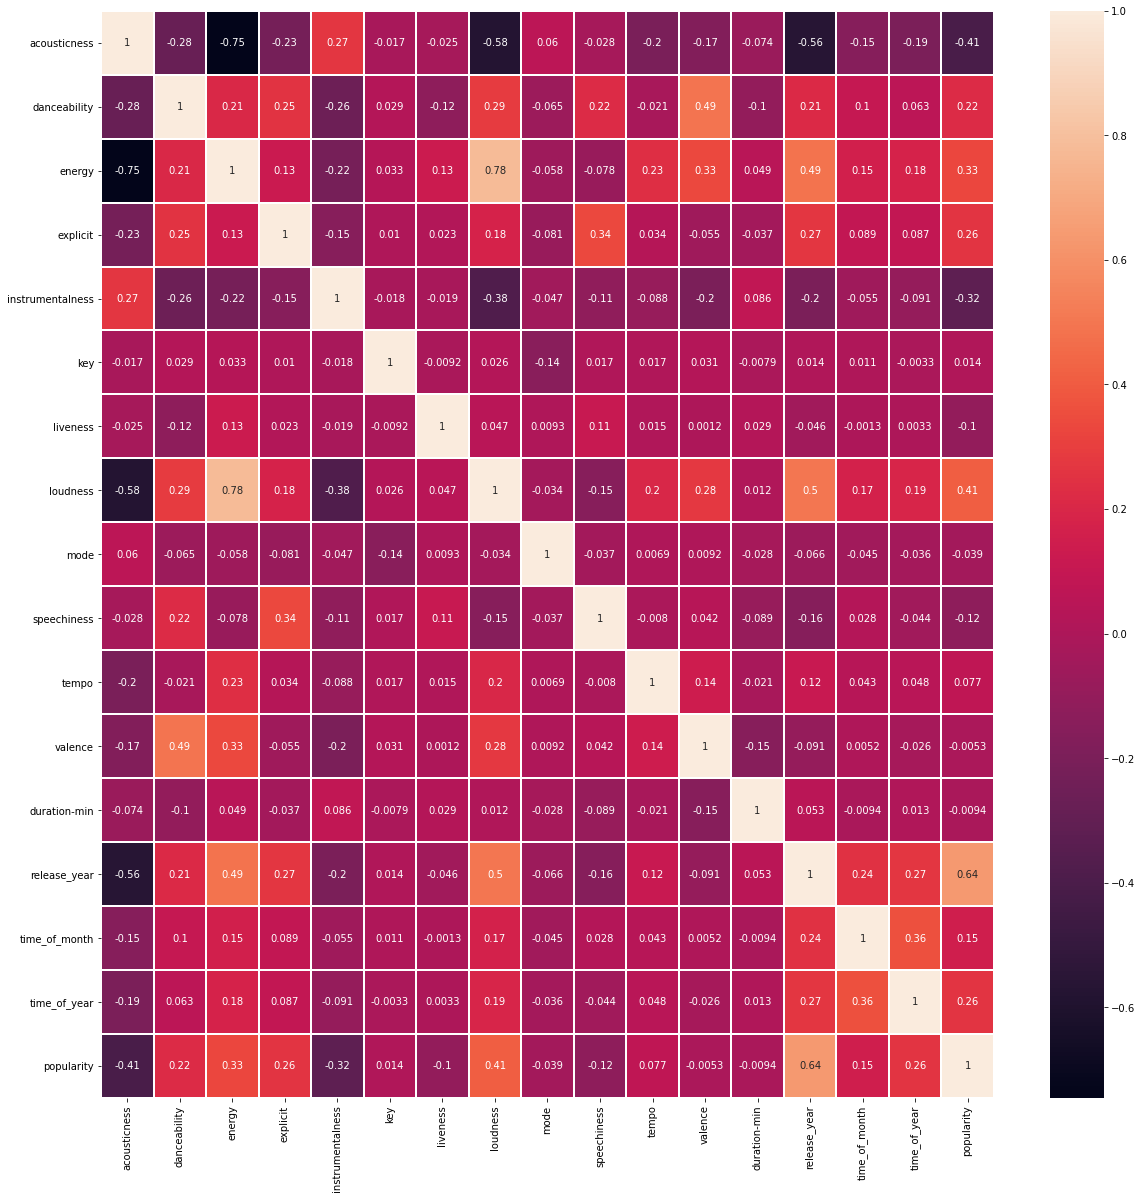

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(),annot=True,linewidths=1,fmt='.2g')

In [9]:
Y = data['popularity']
X = data.drop("popularity",axis=1)
X

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,duration-min,release_year,time_of_month,time_of_year
0,0.9490,0.2350,0.0276,0,0.927000,0.454545,0.513,0.365189,1,0.0381,0.511144,0.03980,0.038567,0.267327,0,1
1,0.8550,0.4560,0.4850,0,0.088400,0.363636,0.151,0.752995,1,0.0437,0.701272,0.85900,0.030303,0.990099,0,1
2,0.8270,0.4950,0.4990,0,0.000000,0.000000,0.401,0.798520,0,0.0474,0.498075,0.70900,0.033058,0.297030,0,1
3,0.6540,0.6430,0.4690,0,0.108000,0.636364,0.218,0.621782,1,0.0368,0.385698,0.96400,0.030303,0.534653,1,2
4,0.7380,0.7050,0.3110,0,0.000000,0.454545,0.322,0.701636,1,0.0488,0.540760,0.78500,0.044077,0.524752,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12222,0.0408,0.8090,0.8010,0,0.000000,0.090909,0.353,0.855467,1,0.4070,0.377877,0.74400,0.044077,0.930693,0,3
12223,0.9120,0.4510,0.2400,0,0.000002,0.090909,0.175,0.664313,1,0.0351,0.618000,0.70100,0.024793,0.386139,0,1
12224,0.3280,0.5510,0.5640,0,0.002950,0.181818,0.352,0.769712,0,0.0338,0.575914,0.89000,0.031680,0.633663,0,1
12225,0.1220,0.0608,0.9390,0,0.991000,0.090909,0.912,0.389192,1,0.1180,0.337728,0.00558,0.039945,0.960396,0,1


In [10]:
X_train,X_CV,Y_train,Y_CV=train_test_split(X,Y,test_size=0.1,random_state=10)

In [11]:
# Lightgbm classifier
import lightgbm as lgb

In [12]:
d_train=lgb.Dataset(X_train, label=Y_train)

In [13]:
def lgbm_classifier(X_train, Y_train, X_CV, Y_CV):
    d_train=lgb.Dataset(X_train, label=Y_train)
    params={}
    params['learning_rate']=0.03
    params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    params['objective']='multiclass' #Multi-class target feature
    params['metric']='multi_logloss' #metric for multi-class
    params['max_depth']=100
    params['num_class']=5
    clf=lgb.train(params,d_train,100)
    y_pred_1=clf.predict(X_CV)
    y_pred = [np.argmax(line) for line in y_pred_1]
    print(metrics.classification_report(Y_CV, y_pred))

In [14]:
lgbm_classifier(X_train, Y_train, X_CV, Y_CV)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       313
           1       0.56      0.72      0.63       297
           2       0.49      0.44      0.46       280
           3       0.68      0.60      0.64       293
           4       0.71      0.30      0.42        40

    accuracy                           0.64      1223
   macro avg       0.65      0.58      0.59      1223
weighted avg       0.64      0.64      0.64      1223



In [15]:
# Dropping time of month
X.drop(columns =["time_of_month"], inplace = True)
X_train,X_CV,Y_train,Y_CV=train_test_split(X,Y,test_size=0.1,random_state=10)
lgbm_classifier(X_train, Y_train, X_CV, Y_CV)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       313
           1       0.57      0.72      0.63       297
           2       0.51      0.45      0.48       280
           3       0.69      0.60      0.65       293
           4       0.71      0.30      0.42        40

    accuracy                           0.64      1223
   macro avg       0.65      0.58      0.60      1223
weighted avg       0.65      0.64      0.64      1223



In [16]:
X.drop(columns =["time_of_year"], inplace = True)
X_train,X_CV,Y_train,Y_CV=train_test_split(X,Y,test_size=0.1,random_state=10)
lgbm_classifier(X_train, Y_train, X_CV, Y_CV)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       313
           1       0.57      0.71      0.63       297
           2       0.51      0.46      0.49       280
           3       0.70      0.60      0.65       293
           4       0.67      0.30      0.41        40

    accuracy                           0.65      1223
   macro avg       0.65      0.58      0.60      1223
weighted avg       0.65      0.65      0.64      1223



In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# from sklearn.preprocessing import Imputer

In [18]:
def xgboost(X_train, Y_train, X_CV, Y_CV):
    model = XGBClassifier()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_CV)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(Y_CV, predictions)
    print(metrics.classification_report(Y_CV, predictions))

In [19]:
def OverSampling(df):
    # define oversampling strategy
    X = df
    y = X.popularity
    X = X.drop(['popularity'], axis=1)
    oversample = RandomOverSampler(sampling_strategy='minority')
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    # summarize class distribution
#     print(Counter(y_over))
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.20, random_state=101)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

In [20]:
data.drop(columns =["time_of_year"], inplace = True)
data.drop(columns =["time_of_month"], inplace = True)
data

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,duration-min,release_year,popularity
0,0.9490,0.2350,0.0276,0,0.927000,0.454545,0.513,0.365189,1,0.0381,0.511144,0.03980,0.038567,0.267327,0
1,0.8550,0.4560,0.4850,0,0.088400,0.363636,0.151,0.752995,1,0.0437,0.701272,0.85900,0.030303,0.990099,1
2,0.8270,0.4950,0.4990,0,0.000000,0.000000,0.401,0.798520,0,0.0474,0.498075,0.70900,0.033058,0.297030,0
3,0.6540,0.6430,0.4690,0,0.108000,0.636364,0.218,0.621782,1,0.0368,0.385698,0.96400,0.030303,0.534653,1
4,0.7380,0.7050,0.3110,0,0.000000,0.454545,0.322,0.701636,1,0.0488,0.540760,0.78500,0.044077,0.524752,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12222,0.0408,0.8090,0.8010,0,0.000000,0.090909,0.353,0.855467,1,0.4070,0.377877,0.74400,0.044077,0.930693,2
12223,0.9120,0.4510,0.2400,0,0.000002,0.090909,0.175,0.664313,1,0.0351,0.618000,0.70100,0.024793,0.386139,4
12224,0.3280,0.5510,0.5640,0,0.002950,0.181818,0.352,0.769712,0,0.0338,0.575914,0.89000,0.031680,0.633663,1
12225,0.1220,0.0608,0.9390,0,0.991000,0.090909,0.912,0.389192,1,0.1180,0.337728,0.00558,0.039945,0.960396,3


In [21]:
X_train, Y_train, X_CV, Y_CV = OverSampling(data)

(12064, 14)
(12064,)
(3016, 14)
(3016,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'eta': [ 0.01, 0.025, 0.05],
        'max_depth': [ 9, 12],
        'min_child_weight': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.5, 0.7],
        'lambda' : [0.8, 1.0, 1.5],
        'alpha' : [0.05, 0.1, 0.5],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    # rsearch = RandomizedSearchCV(estimator = xgb_model,
    #                        param_grid = param_tuning,                        
    #                        #scoring = 'neg_mean_absolute_error', #MAE
    #                        #scoring = 'neg_mean_squared_error',  #MSE
    #                        cv = 5,
    #                        n_jobs = -1)
    rsearch = RandomizedSearchCV(xgb_model,param_tuning ,n_jobs=-1, cv=5, random_state=1)

    rsearch.fit(X_train,y_train)

    return rsearch.best_params_

In [50]:
# xgboost(X_train, Y_train, X_CV, Y_CV)
hyperParameterTuning(X_train, Y_train)
# {'alpha': 0.1,
#  'colsample_bytree': 0.7,
#  'eta': 0.01,
#  'lambda': 1.0,
#  'max_depth': 12,
#  'min_child_weight': 5,
#  'objective': 'reg:squarederror',
#  'subsample': 0.8}

{'alpha': 0.1,
 'colsample_bytree': 0.7,
 'eta': 0.01,
 'lambda': 1.0,
 'max_depth': 12,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [45]:
def xgboost_hyperparameter(X_train, Y_train, X_CV, Y_CV):
    xgb_model = XGBRegressor(
        alpha = 0.1,
        colsample_bytree =  0.7,
        eta = 0.01,
        reg_lambda = 1.0,
        max_depth = 12,
        min_child_weight = 5,
        objective = 'reg:squarederror',
        subsample = 0.8)

    xgb_model.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_CV, Y_CV)], verbose=False)
    y_pred_xgb = xgb_model.predict(X_CV)
    predictions = [round(value) for value in y_pred_xgb]
    print(metrics.classification_report(Y_CV, predictions))

In [53]:
xgboost_hyperparameter(X, Y, X, Y)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3222
           1       0.94      0.99      0.96      3118
           2       0.92      0.99      0.95      2912
           3       0.97      0.92      0.94      2606
           4       1.00      0.80      0.89       369

    accuracy                           0.96     12227
   macro avg       0.96      0.93      0.94     12227
weighted avg       0.96      0.96      0.95     12227

